In [1]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

# Descargar y mirar los datos

In [3]:
# Sunspots.csv
!gdown --id 1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5

"gdown" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


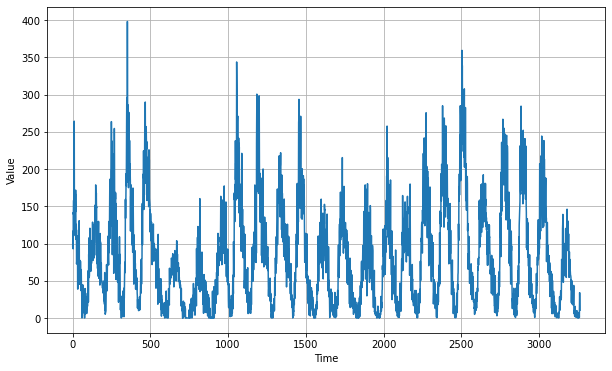

In [5]:
import csv
time_step = []
sunspots = []

with open('./Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
# Definir Train y Test

In [6]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

## Funciones Auxiliares

Para crear los arrays con ventanas de tiempo (a utilizar por la RNN).

Para hacer forecasting

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
## Utilizar función auxiliar para crear train set a ser consumido por la RNN

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


In [9]:
%%time

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

# Esto es una opción avanzada para ir reduciendo el learning rate a medida que aumenta el número de epochs
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
12/12 [==============================] - 7s 229ms/step - loss: 79.8340 - mae: 80.3314 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 3s 263ms/step - loss: 78.0944 - mae: 78.5918 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 4s 275ms/step - loss: 75.4519 - mae: 75.9497 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 4s 279ms/step - loss: 72.2678 - mae: 72.7658 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 4s 318ms/step - loss: 68.7693 - mae: 69.2672 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 5s 363ms/step - loss: 65.1128 - mae: 65.6099 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 4s 253ms/step - loss: 61.5272 - mae: 62.0241 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 4s 307ms/step - loss: 58.1406 - mae: 58.6369 - lr: 2.2387e-08
Epoch 9/100
12/12 [==============================] - 4s 306ms/step - loss: 55.07

(1e-08, 0.0001, 0.0, 60.0)

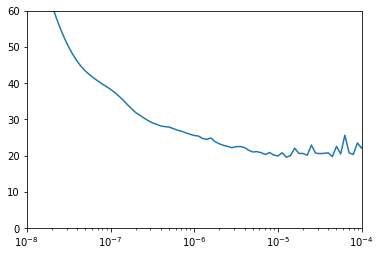

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=300)

Epoch 1/300
30/30 [==============================] - 6s 76ms/step - loss: 38.9180 - mae: 39.4144
Epoch 2/300
30/30 [==============================] - 2s 76ms/step - loss: 25.7635 - mae: 26.2579
Epoch 3/300
30/30 [==============================] - 3s 87ms/step - loss: 22.0814 - mae: 22.5751
Epoch 4/300
30/30 [==============================] - 3s 85ms/step - loss: 20.4758 - mae: 20.9688
Epoch 5/300
30/30 [==============================] - 3s 104ms/step - loss: 19.7139 - mae: 20.2063
Epoch 6/300
30/30 [==============================] - 3s 102ms/step - loss: 19.3139 - mae: 19.8061
Epoch 7/300
30/30 [==============================] - 3s 96ms/step - loss: 18.7654 - mae: 19.2576
Epoch 8/300
30/30 [==============================] - 3s 91ms/step - loss: 18.1193 - mae: 18.6109
Epoch 9/300
30/30 [==============================] - 5s 147ms/step - loss: 18.0773 - mae: 18.5689
Epoch 10/300
30/30 [==============================] - 5s 157ms/step - loss: 17.8861 - mae: 18.3772
Epoch 11/300
30/30 [=====

KeyboardInterrupt: 

In [11]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [12]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

12.977564

ValueError: x and y must have same first dimension, but have shapes (300,) and (0,)

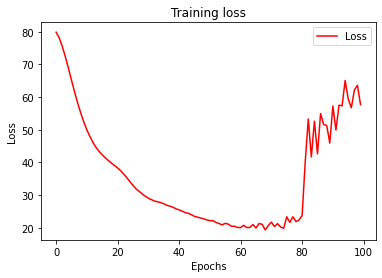

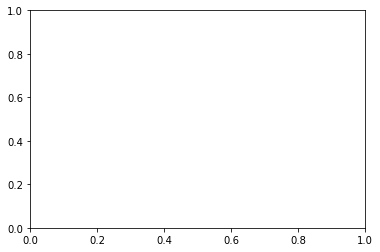

In [14]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [15]:
print(rnn_forecast)

[122.83087   106.00791   113.0244    118.49749   109.09368   144.34592
 172.4753    172.7953    164.67953   137.02841   161.42418   172.52177
 136.55873   143.8591    158.46844   178.58533   176.9283    163.706
 166.75427   193.12709   164.73909   158.55656   146.41293   158.72525
 144.62122   139.30751   132.45323   150.22824   151.03844   135.47577
 165.23566   132.52959   138.8861    180.53738   154.04178   158.38821
 174.97449   158.91548   150.72682   147.24951   164.65173   166.41388
 140.43767   149.88177   160.09012   157.72162   148.24161   140.29372
 130.59297   130.6988    102.626205  105.487045  106.98526    98.00141
 115.73355   118.59023   106.630035   87.51509    90.73361    82.464775
  72.80128    64.639244   71.372246   73.485245   61.20918    66.19935
  62.33468    72.606255   64.56281    49.18835    63.328182   66.265724
  42.129444   44.869488   44.651203   42.630505   35.175133   48.53321
  44.43397    47.527496   45.932938   30.3356     28.189358   24.362911
  34.

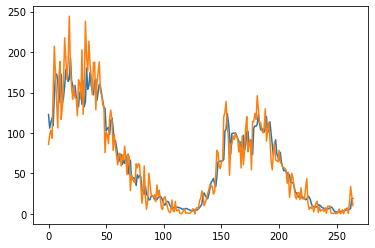

In [16]:
plt.plot(rnn_forecast)
plt.plot(x_valid)

### Ejemplo usando Librerias de Series de tiempo [Solo para mirar que son problemas complejos]

In [22]:
import pandas as pd
from fbprophet import Prophet

ModuleNotFoundError: No module named 'fbprophet'

In [36]:
# Cargamos los datos y los dejamos en el formato que le gusta a prophet
df = pd.read_csv('./Sunspots.csv', usecols= [1, 2], parse_dates=["Date"])
df.columns = ["ds", "y"]
df.head()

,ds,y
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [39]:
train = df.loc[:3000]
valid = df.loc[3001:]

In [41]:
m = Prophet()
m.fit(train)
forecast = m.predict(valid)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [43]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1999-02-28,106.276688,28.884141,193.683959,106.276688,106.276688,1.739434,1.739434,1.739434,1.739434,1.739434,1.739434,0.0,0.0,0.0,108.016122
1,1999-03-31,106.296450,15.685982,190.469833,106.296450,106.296450,-0.154136,-0.154136,-0.154136,-0.154136,-0.154136,-0.154136,0.0,0.0,0.0,106.142314
2,1999-04-30,106.315575,17.546339,193.713075,106.315575,106.315575,-1.688272,-1.688272,-1.688272,-1.688272,-1.688272,-1.688272,0.0,0.0,0.0,104.627302
3,1999-05-31,106.335337,17.687923,189.480343,106.335337,106.335337,-2.518129,-2.518129,-2.518129,-2.518129,-2.518129,-2.518129,0.0,0.0,0.0,103.817208
4,1999-06-30,106.354461,22.592064,189.484496,106.354461,106.354461,-0.157999,-0.157999,-0.157999,-0.157999,-0.157999,-0.157999,0.0,0.0,0.0,106.196462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,2018-03-31,110.720607,26.911424,194.457719,108.027799,113.579946,-0.463321,-0.463321,-0.463321,-0.463321,-0.463321,-0.463321,0.0,0.0,0.0,110.257285
230,2018-04-30,110.739731,24.973884,200.063145,108.030268,113.614290,-1.458428,-1.458428,-1.458428,-1.458428,-1.458428,-1.458428,0.0,0.0,0.0,109.281303
231,2018-05-31,110.759493,28.950514,195.895103,108.033054,113.649778,-1.771063,-1.771063,-1.771063,-1.771063,-1.771063,-1.771063,0.0,0.0,0.0,108.988430
232,2018-06-30,110.778618,24.644955,188.675490,108.036177,113.684096,-0.110493,-0.110493,-0.110493,-0.110493,-0.110493,-0.110493,0.0,0.0,0.0,110.668125


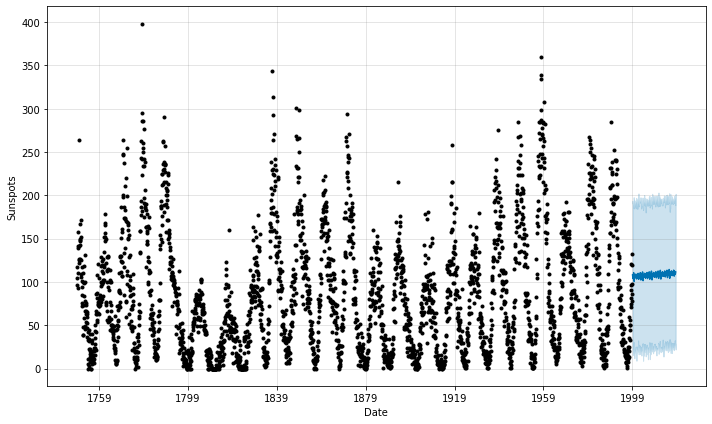

In [42]:
figure = m.plot(forecast, xlabel='Date', ylabel='Sunspots')

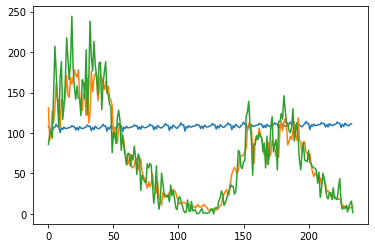

In [45]:
plt.plot(forecast["yhat"])
plt.plot(rnn_forecast)
plt.plot(x_valid)

DARTS

In [47]:
!pip install darts

     |████████████████████████████████| 290 kB 4.9 MB/s 
     |████████████████████████████████| 9.8 MB 31.8 MB/s 
     |████████████████████████████████| 155 kB 31.4 MB/s 
     |████████████████████████████████| 177 kB 48.9 MB/s 
     |████████████████████████████████| 65 kB 3.9 MB/s 
     |████████████████████████████████| 1.4 MB 40.7 MB/s 
     |████████████████████████████████| 791 kB 41.6 MB/s 
     |████████████████████████████████| 11.2 MB 43.6 MB/s 
     |████████████████████████████████| 374 kB 45.2 MB/s 
     |████████████████████████████████| 884 kB 42.4 MB/s 
     |████████████████████████████████| 49 kB 4.9 MB/s 
     |████████████████████████████████| 216 kB 47.9 MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=efa9e745657465517d0e9f0ddec386c95538168674de648719aa6d788ac1b2c9
  Stored in directory: /root/.cache/pip/wheels/ce/e0/ee/a2b3c5caab3418c1ccd8c4de573d4cbe13315d7e8b0a55fbc2
  Created wheel for prophet: filename=prophet-

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
import darts.utils.timeseries_generation as tg
from darts.datasets import AirPassengersDataset, EnergyDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.missing_values import fill_missing_values
from darts.utils.likelihood_models import GaussianLikelihood

In [51]:
series = TimeSeries.from_dataframe(df, 'ds', 'y')
train, val = series[:3000], series[3001:]

In [52]:
series

<TimeSeries (DataArray) (ds: 3235, component: 1, sample: 1)>
array([[[ 96.7]],

       [[104.3]],

       [[116.7]],

       ...,

       [[ 13.2]],

       [[ 15.9]],

       [[  1.6]]])
Coordinates:
  * ds         (ds) datetime64[ns] 1749-01-31 1749-02-28 ... 2018-07-31
  * component  (component) object 'y'
Dimensions without coordinates: sample

In [54]:
my_model = RNNModel(
    model='LSTM',
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=50,
    optimizer_kwargs={'lr': 1e-3},
    random_state=0,
    training_length=50,
    input_chunk_length=20,
    likelihood=GaussianLikelihood()
)

my_model.fit(train,  
             verbose=True)

[2021-12-12 23:00:49,714] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 2950 samples.
[2021-12-12 23:00:49,714] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 2950 samples.
INFO:darts.models.forecasting.torch_forecasting_model:Train dataset contains 2950 samples.
[2021-12-12 23:00:49,742] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-12 23:00:49,742] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
INFO:darts.models.forecasting.torch_forecasting_model:Time series values are 64-bits; casting model to float64.
  2%|▏         | 1/50 [00:02<02:21,  2.88s/it]

 22%|██▏       | 11/50 [00:29<01:45,  2.70s/it]

 42%|████▏     | 21/50 [00:56<01:18,  2.69s/it]

 62%|██████▏   | 31/50 [01:23<00:51,  2.70s/it]

 82%|████████▏ | 41/50 [01:50<00:24,  2.69s/it]

100%|██████████| 50/50 [02:14<00:00,  2.70s/it]


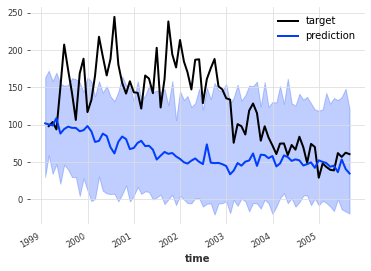

In [55]:
pred = my_model.predict(80, num_samples=50)
val.slice_intersect(pred).plot(label='target')
pred.plot(label='prediction')

In [57]:
series[3000]

<TimeSeries (DataArray) (ds: 1, component: 1, sample: 1)>
array([[[86.]]])
Coordinates:
  * ds         (ds) datetime64[ns] 1999-01-31
  * component  (component) object 'y'
Dimensions without coordinates: sample

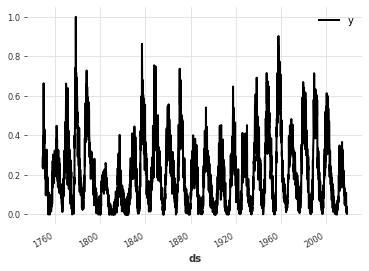

In [58]:
# scale
scaler_en = Scaler()
series_en_transformed = scaler_en.fit_transform(series)
train_en_transformed, val_en_transformed = series_en_transformed.split_after(pd.Timestamp('19990131'))

# add the day as a covariate
day_series = datetime_attribute_timeseries(series_en_transformed, attribute='month', one_hot=True)
scaler_day = Scaler()
day_series = scaler_day.fit_transform(day_series)
train_day, val_day = day_series.split_after(pd.Timestamp('19990131'))

series_en_transformed.plot()

In [59]:
model_en = RNNModel(
    model='LSTM',
    hidden_dim=20,
    n_rnn_layers=2,
    dropout=0.2,
    batch_size=256,
    n_epochs=10,
    optimizer_kwargs={'lr': 1e-3},
    random_state=0,
    training_length=60,
    input_chunk_length=300,
    likelihood=GaussianLikelihood()
)

In [60]:
model_en.fit(series=train_en_transformed, 
             future_covariates=train_day,
             verbose=True)

[2021-12-12 23:05:52,312] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 2941 samples.
[2021-12-12 23:05:52,312] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 2941 samples.
INFO:darts.models.forecasting.torch_forecasting_model:Train dataset contains 2941 samples.
[2021-12-12 23:05:52,327] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-12 23:05:52,327] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
INFO:darts.models.forecasting.torch_forecasting_model:Time series values are 64-bits; casting model to float64.
 10%|█         | 1/10 [00:02<00:18,  2.10s/it]

100%|██████████| 10/10 [00:20<00:00,  2.00s/it]


In [61]:
backtest_en = model_en.historical_forecasts(series=series_en_transformed,
                                            future_covariates=day_series,
                                            num_samples=50,
                                            start=0.7,
                                            forecast_horizon=30,
                                            stride=5,
                                            retrain=False,
                                            verbose=True)

100%|██████████| 189/189 [00:25<00:00,  7.33it/s]


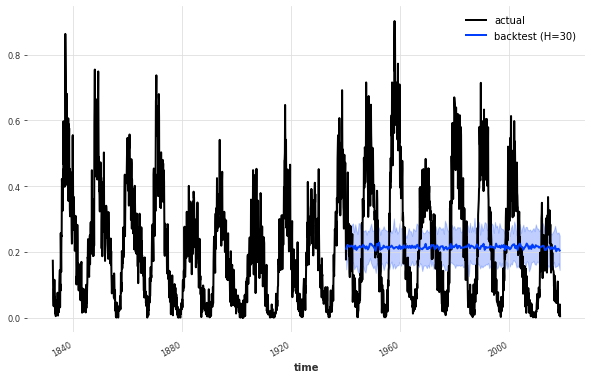

In [62]:
plt.figure(figsize=(10,6))
series_en_transformed[1000:].plot(label='actual')
backtest_en.plot(label='backtest (H=30)', low_quantile=0.01, high_quantile=0.99)
plt.legend()